Import libraries and tools

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
import joblib
from scipy.stats import randint,uniform

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score

1. Load the dataset into pandas dataframe.
2. Check for shape, datatype of columns, number of null values, any duplicate rows.

In [3]:
df=pd.read_csv("C:/Users/arnav/Desktop/Python_projects/EDA/fault_classification/data/detect_dataset.csv")
print(df.isnull().sum())
print(df.dtypes)
print(df.shape)
print(df.duplicated().sum())

Output (S)        0
Ia                0
Ib                0
Ic                0
Va                0
Vb                0
Vc                0
Unnamed: 7    12001
Unnamed: 8    12001
dtype: int64
Output (S)      int64
Ia            float64
Ib            float64
Ic            float64
Va            float64
Vb            float64
Vc            float64
Unnamed: 7    float64
Unnamed: 8    float64
dtype: object
(12001, 9)
0


Drop unnecessary columns and rename the target column.

In [4]:
df.drop(columns=['Unnamed: 7','Unnamed: 8'],inplace=True)
df.rename(columns={'Output (S)':'target'},inplace=True)
df

,target,Ia,Ib,Ic,Va,Vb,Vc
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050
...,...,...,...,...,...,...,...
11996,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
11997,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
11998,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
11999,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


To show the class distribution in order to determine class imbalance in the dataset

target
0    6505
1    5496
Name: count, dtype: int64


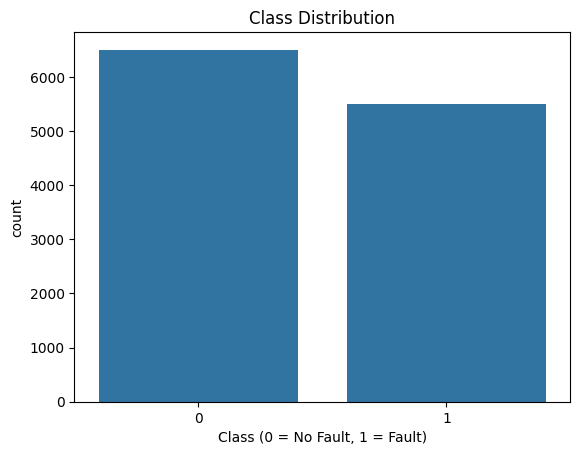

,target,Ia,Ib,Ic,Va,Vb,Vc
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050
...,...,...,...,...,...,...,...
11996,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
11997,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
11998,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
11999,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


In [5]:
counts=df['target'].value_counts()
print(counts)
sns.countplot(x='target',data=df)
plt.title('Class Distribution')
plt.xlabel("Class (0 = No Fault, 1 = Fault)")
plt.show()
df

# Histograms are plotted for Phase current and voltages to understand their behavior during normal & fault condition. 
- Low and balanced current: normal
- Large current magnitude spread: fault condition
- Small voltage fluctuation during normal condition
- Voltage dip during fault condition

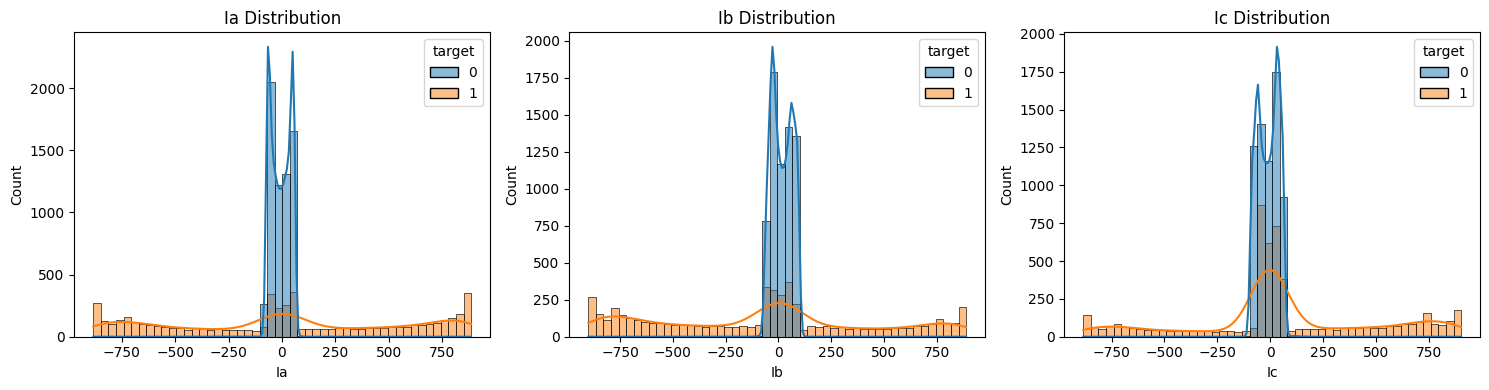

In [6]:
fig,axes=plt.subplots(1,3, figsize=(15,4))
current=['Ia','Ib','Ic']

for i,c in enumerate(current):
    sns.histplot(data=df,x=c,hue='target',bins=50,kde=True,ax=axes[i])
    axes[i].set_title(f'{c} Distribution')

plt.tight_layout()
plt.show()

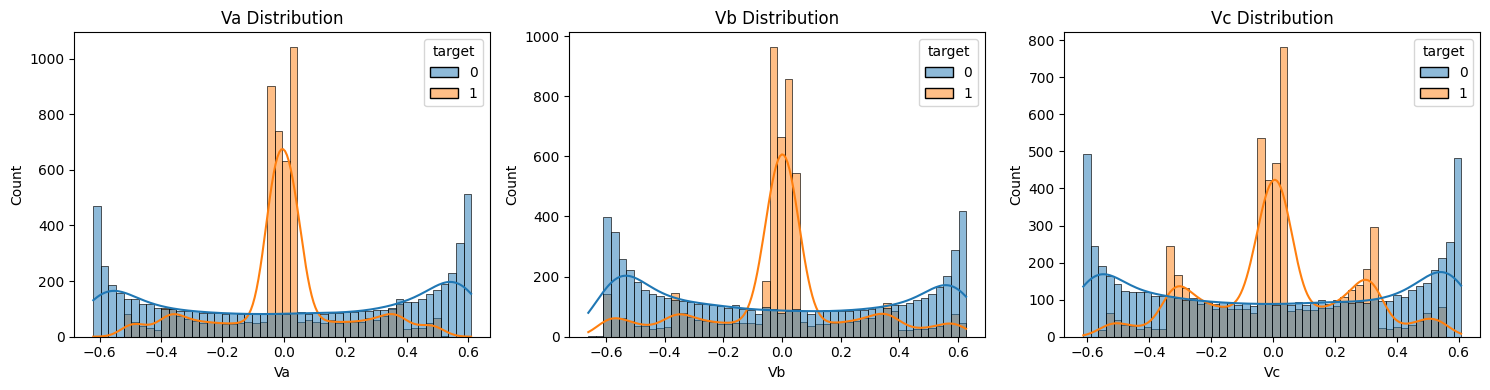

In [7]:
fig,axes=plt.subplots(1,3, figsize=(15,4))
voltage=['Va','Vb','Vc']

for i,c in enumerate(voltage):
    sns.histplot(data=df,x=c,hue='target',bins=50,kde=True,ax=axes[i])
    axes[i].set_title(f'{c} Distribution')

plt.tight_layout()
plt.show()

# Boxplots for the parameters separeated by class. 

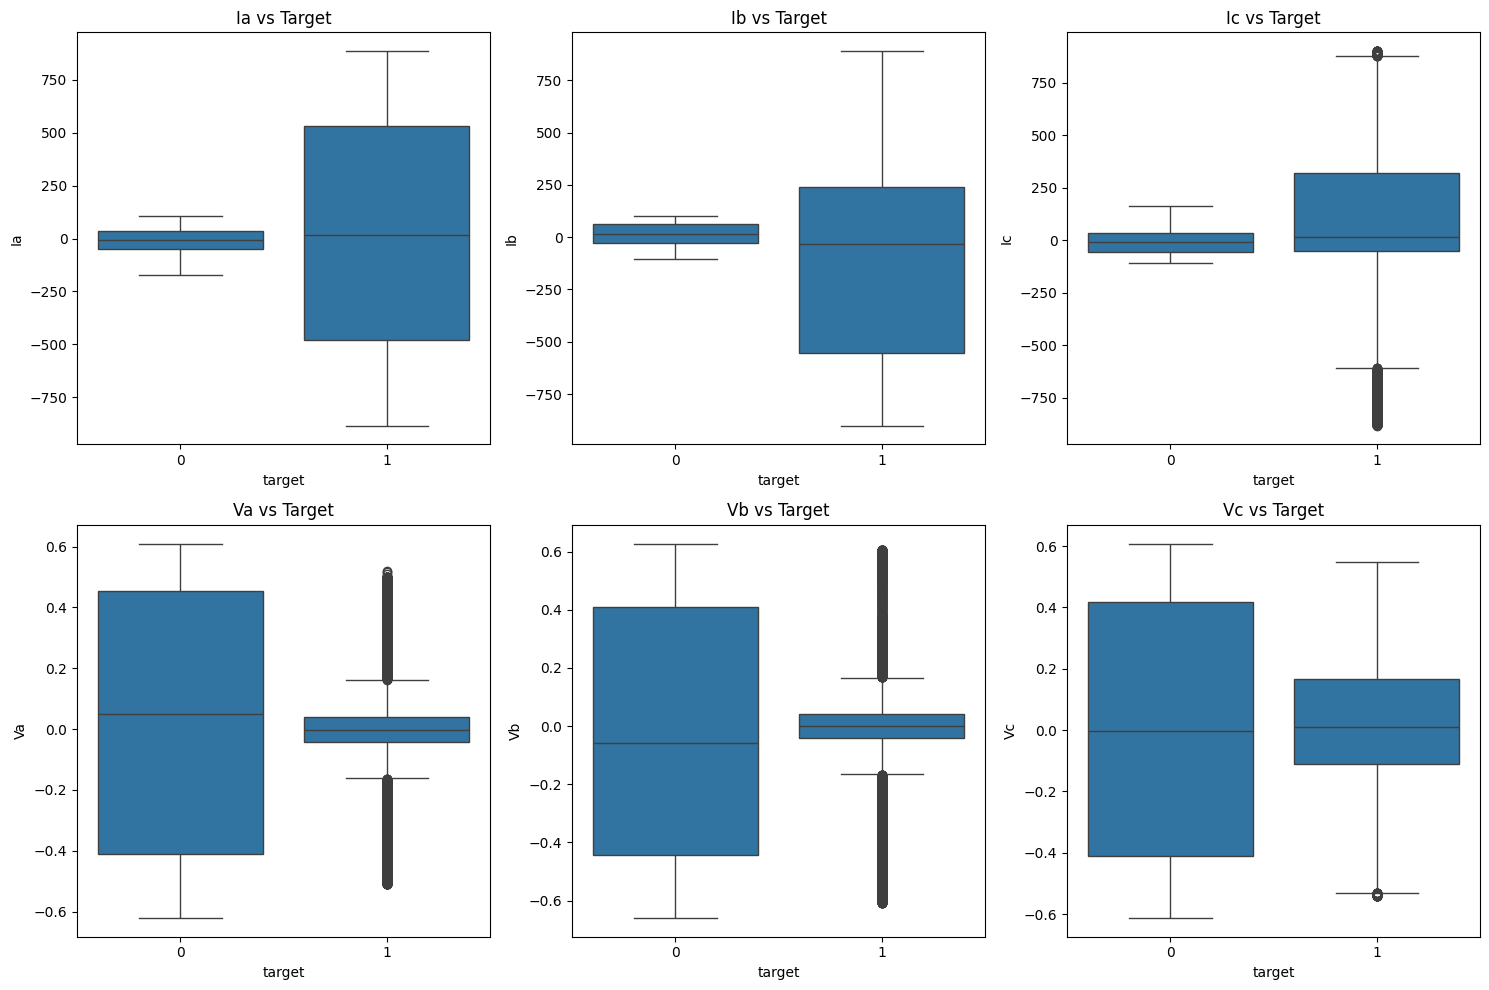

In [8]:
fig,axes=plt.subplots(2,3, figsize=(15,10))
axes=axes.flatten()

parameters=['Ia','Ib','Ic','Va','Vb','Vc']

for ax,c in zip(axes, parameters):
    sns.boxplot(data=df,y=c,x='target',ax=ax)
    ax.set_title(f'{c} vs Target')

plt.tight_layout()
plt.show()

# Heatmap is generated to show correlation between features. 

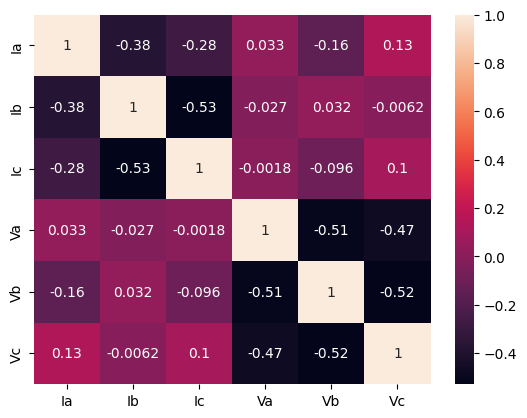

In [9]:
features=df[['Ia','Ib','Ic','Va','Vb','Vc']]
sns.heatmap(features.corr(),annot=True)
plt.show()

# Calculate the RMS values for current and voltage.

In [10]:
WINDOW= 60

for col in ['Ia','Ib','Ic','Va','Vb','Vc']:
    df[f'{col}_rms'] = (
        df[col]
        .rolling(WINDOW, min_periods=1)
        .apply(lambda x: np.sqrt((x**2).mean()))
    )



In [11]:
df.shape

(12001, 13)

# Histograms, boxplots and heatmap for RMS values are plotted.

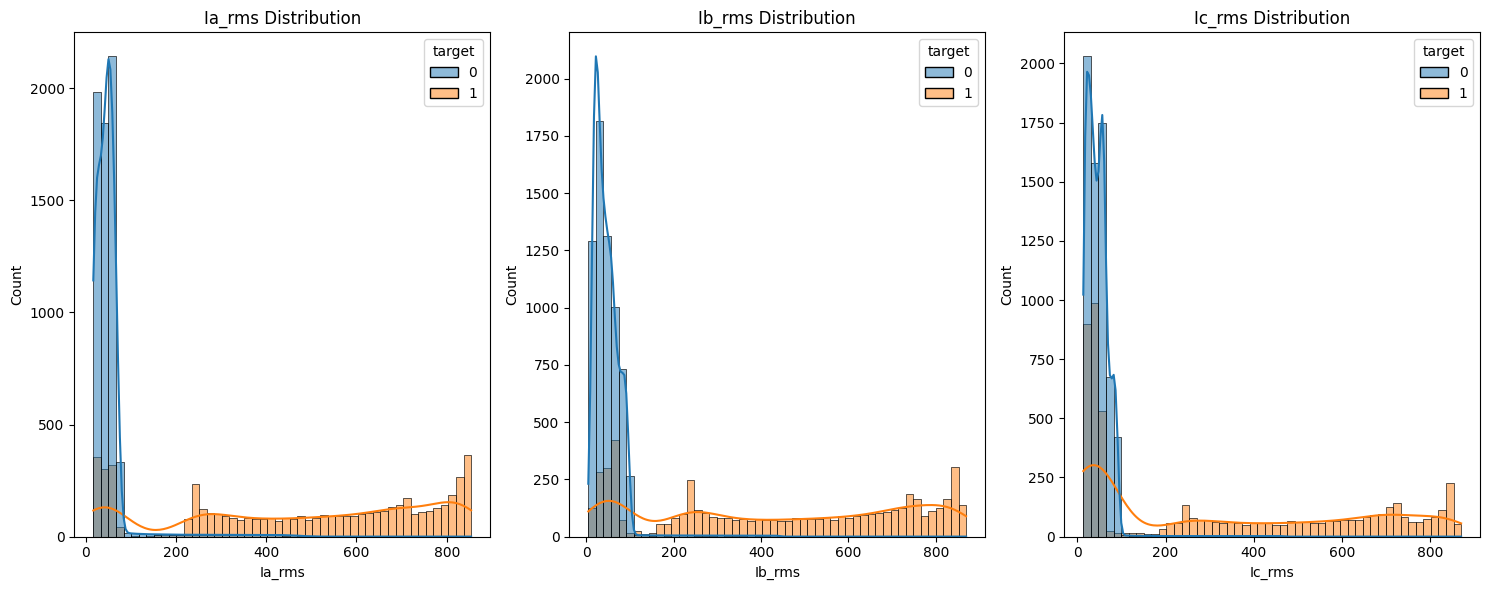

In [12]:
fig,axes=plt.subplots(1,3, figsize=(15,6))
rms_current=['Ia_rms','Ib_rms','Ic_rms']

for i,c in enumerate(rms_current):
    sns.histplot(data=df,x=c,hue='target',bins=50,kde=True,ax=axes[i])
    axes[i].set_title(f'{c} Distribution')

plt.tight_layout()
plt.show()

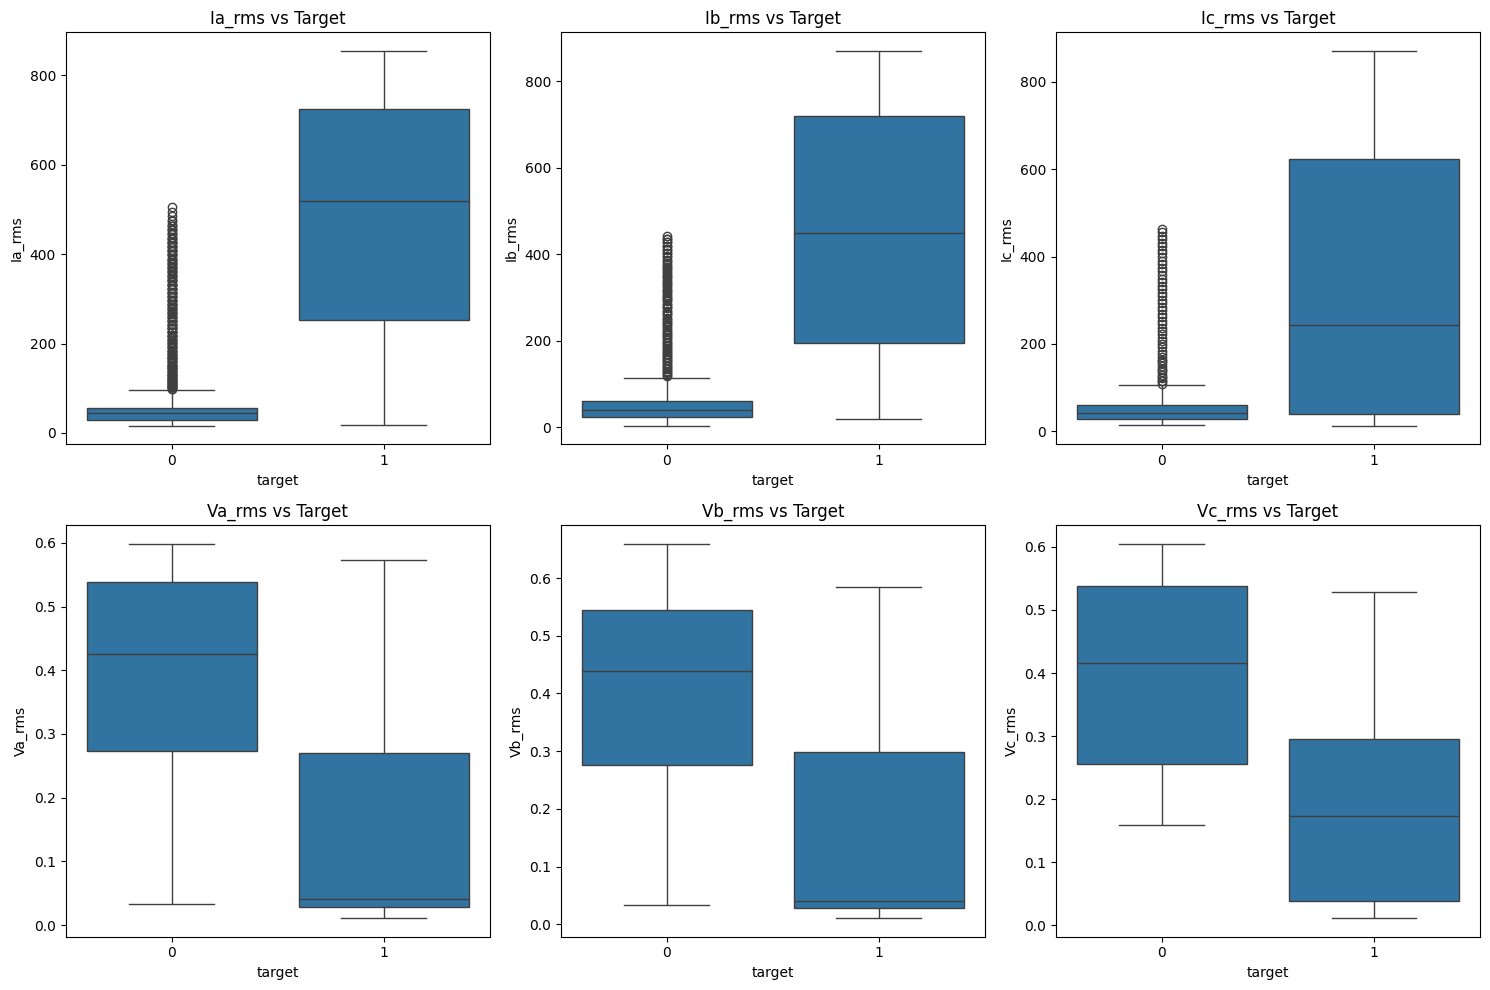

In [13]:
fig,axes=plt.subplots(2,3, figsize=(15,10))
axes=axes.flatten()

parameters=['Ia_rms','Ib_rms','Ic_rms','Va_rms','Vb_rms','Vc_rms']

for ax,c in zip(axes, parameters):
    sns.boxplot(data=df,y=c,x='target',ax=ax)
    ax.set_title(f'{c} vs Target')

plt.tight_layout()
plt.show()

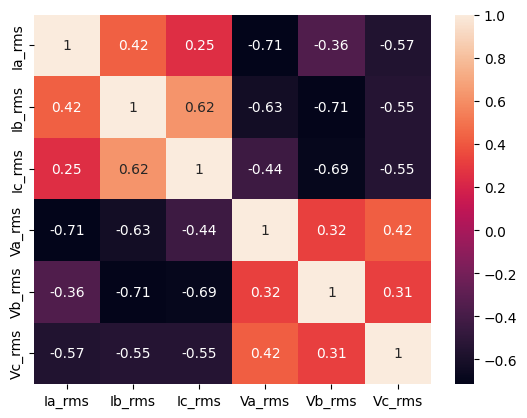

In [14]:
rms_features=df[['Ia_rms','Ib_rms','Ic_rms','Va_rms','Vb_rms','Vc_rms']]

sns.heatmap(rms_features.corr(),annot=True)
plt.show()

# Select feature list and perform train test split

In [15]:
feature_list= ['Ia','Ib','Ic','Va','Vb','Vc','Ia_rms','Ib_rms','Ic_rms','Va_rms','Vb_rms','Vc_rms']
target='target'

X=df[feature_list]
y=df[target]

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Create a preprocessing pipeline, fit and predict, find model metrics

In [17]:
lr_pipe=Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

In [18]:
lr_pipe.fit(X_train,y_train)

,steps,"[('scaler', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [19]:
y_pred=lr_pipe.predict(X_test)

print('Accuracy:',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Accuracy: 0.9891711786755518
[[1291   10]
 [  16 1084]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1301
           1       0.99      0.99      0.99      1100

    accuracy                           0.99      2401
   macro avg       0.99      0.99      0.99      2401
weighted avg       0.99      0.99      0.99      2401



# Make a dictionary containing various models, fit scaler on required models, train and predict, and compare individual metrics.

In [20]:
models={
    "lr":Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())]),

    "SVM":Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', SVC())]),

    "KNN":Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())])
   
}

In [21]:
models.update({
    "rf":Pipeline(steps=[
        ('clf', RandomForestClassifier())
    ])
})

In [22]:
results={}

for name, model in models.items():
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    results[name]={
        'Accuracy': accuracy_score(y_test,y_pred),
        'F1 score': f1_score(y_test,y_pred)
    }

results_df=pd.DataFrame(results).T
results_df

,Accuracy,F1 score
lr,0.989171,0.988149
SVM,0.994586,0.994120
KNN,0.997501,0.997275
rf,0.996252,0.995911


# Random Forest is chosen as the final model due to it's high scores. RandomizedSearch CV is used to find the best hyperparameters. Then they are used to fit, predict and find model metrics. 

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_param_dist = {
    'clf__n_estimators': [100, 250, 500],
    'clf__max_depth': [None, 10, 25, 50],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', None]
}

In [33]:
rf_param_dist = {
    'clf__n_estimators': randint(100, 600),
    'clf__max_depth': [None] + list(range(10,101,10)),
    'clf__min_samples_split': randint(2, 11),
    'clf__min_samples_leaf': randint(1, 5),
    'clf__max_features': ['sqrt', 'log2', None]
}

rf_rand = RandomizedSearchCV(
    models['rf'],
    param_distributions=rf_param_dist,
    n_iter=40,
    scoring='f1',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=2,
    refit=True
)
rf_rand.fit(X_train, y_train)
print("Best params (rand):", rf_rand.best_params_)

y_pred = rf_rand.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (rand): {'clf__max_depth': 100, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 9, 'clf__n_estimators': 332}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1301
           1       1.00      1.00      1.00      1100

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401

[[1296    5]
 [   1 1099]]


In [35]:
print("Best CV f1:", rf_rand.best_score_)

Best CV f1: 0.9978429061338424


# Feature importance table is created and a chart is plotted.

In [36]:
best_rf = rf_rand.best_estimator_

importances = best_rf.named_steps['clf'].feature_importances_

feature_names = X_train.columns

import pandas as pd

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

fi_df

,Feature,Importance
6,Ia_rms,0.288799
7,Ib_rms,0.197998
9,Va_rms,0.113417
10,Vb_rms,0.102222
0,Ia,0.072828
8,Ic_rms,0.068209
11,Vc_rms,0.056011
1,Ib,0.050458
2,Ic,0.020387
3,Va,0.015580


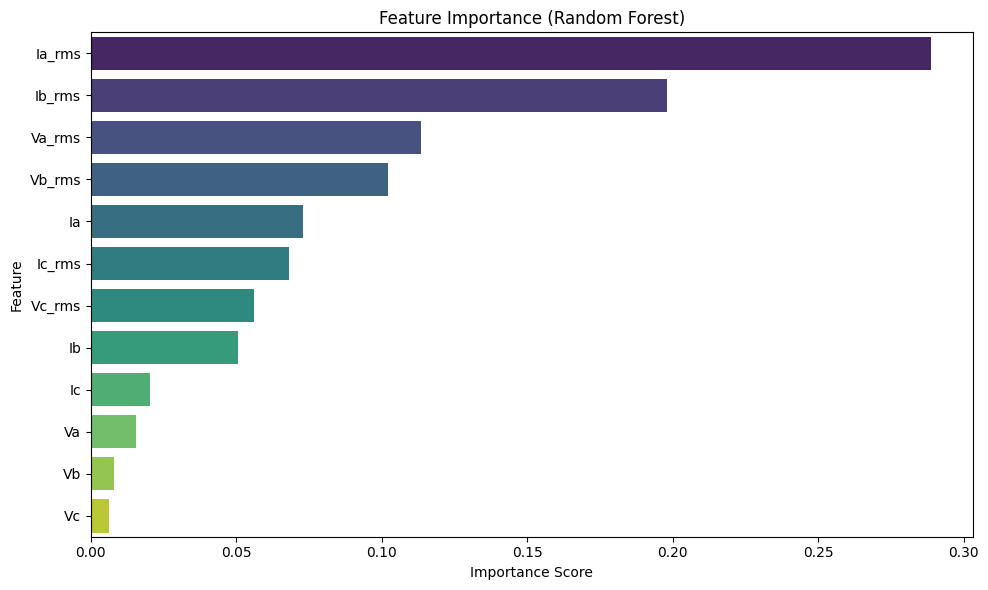

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=fi_df,
    y='Feature',
    x='Importance',
    hue='Feature',
    palette='viridis'
)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
